In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import string
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import losses
from keras import utils
from keras import Model
from keras.models import Sequential
from keras.layers import LSTM, TextVectorization, Embedding, Dense, Bidirectional, InputLayer
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
import imblearn
import optuna
tf.keras.utils.set_random_seed(42069)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


PART 1: DATA PREPROCESSING

In [4]:
# functions for data preprocessing
def remove_tags(sentence):
    """
    removes <e1>, </e1>, <e2>, and </e2> tags from a given sentence
    """
    tags = ['<e1>', '</e1>', '<e2>', '</e2>']
    for tag in tags:
        sentence = sentence.replace(tag, '')
    return sentence


def load_data(file_path):
    """
    loads the sentences and their corresponding labels from a file into a Pandas dataframe
    """
    # read the file and split the lines
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()

    # split each line into the sentence and the label
    data = []
    for i in range(0, len(lines), 4):
        relation_to_label = {
            'Other': 0.0, 
            'Cause-Effect(e1,e2)': 1.0, 
            'Cause-Effect(e2,e1)': 2.0,
            'Component-Whole(e1,e2)': 3.0, 
            'Component-Whole(e2,e1)': 4.0,
            'Product-Producer(e1,e2)': 5.0, 
            'Product-Producer(e2,e1)': 6.0,
            'Instrument-Agency(e1,e2)': 7.0,
            'Instrument-Agency(e2,e1)': 8.0
        }
        sentence = remove_tags(lines[i].split('\t')[1])
        relation = lines[i + 1]
        if relation not in relation_to_label:
            relation = 'Other'
        data.append([sentence, relation_to_label[relation]])
    # create a dataframe from the data
    df = pd.DataFrame(data, columns=['sentence', 'label'])
    return df

In [5]:
# load train and test sets into pandas dataframes
train_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'cs6320', 'SemEval2010', 'train', 'TRAIN_FILE.TXT') 
test_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'cs6320', 'SemEval2010', 'test_keys', 'TEST_FILE_FULL.TXT') 
train_df = load_data(train_path)
test_df = load_data(test_path)

In [6]:
# initialize tokenizer
MAX_SEQ_LEN = 85
VOCAB_SIZE = 25000
tokenizer = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=MAX_SEQ_LEN)
tokenizer.adapt(train_df['sentence'].values)

In [7]:
# create train, val, and test sets
x_train = train_df['sentence']
y_train = train_df['label']
x_test = test_df['sentence']
y_test = test_df['label']
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42069, stratify=y_train)

In [8]:
label_to_relation = {
    0: 'Other', 
    1: 'Cause-Effect(e1,e2)', 
    2: 'Cause-Effect(e2,e1)',
    3: 'Component-Whole(e1,e2)', 
    4: 'Component-Whole(e2,e1)',
    5: 'Product-Producer(e1,e2)', 
    6: 'Product-Producer(e2,e1)',
    7: 'Instrument-Agency(e1,e2)', 
    8: 'Instrument-Agency(e2,e1)'
}
y_train_viz = y_train.replace(label_to_relation)
y_val_viz = y_val.replace(label_to_relation)
y_test_viz = y_test.replace(label_to_relation)

In [9]:
# count of relations in train set
pd.concat([y_train_viz.value_counts(), 100 * y_train_viz.value_counts(normalize=True)], axis=1, keys=['count', '%'])

,count,%
Other,4351,60.430556
"Cause-Effect(e2,e1)",593,8.236111
"Component-Whole(e2,e1)",424,5.888889
"Component-Whole(e1,e2)",423,5.875000
"Instrument-Agency(e2,e1)",366,5.083333
"Product-Producer(e2,e1)",355,4.930556
"Cause-Effect(e1,e2)",310,4.305556
"Product-Producer(e1,e2)",291,4.041667
"Instrument-Agency(e1,e2)",87,1.208333


In [10]:
# count of relations in val set
pd.concat([y_val_viz.value_counts(), 100 * y_val_viz.value_counts(normalize=True)], axis=1, keys=['count', '%'])

,count,%
Other,484,60.500
"Cause-Effect(e2,e1)",66,8.250
"Component-Whole(e1,e2)",47,5.875
"Component-Whole(e2,e1)",47,5.875
"Instrument-Agency(e2,e1)",41,5.125
"Product-Producer(e2,e1)",39,4.875
"Cause-Effect(e1,e2)",34,4.250
"Product-Producer(e1,e2)",32,4.000
"Instrument-Agency(e1,e2)",10,1.250


In [11]:
# count of relations in test set
pd.concat([y_test_viz.value_counts(), 100 * y_test_viz.value_counts(normalize=True)], axis=1, keys=['count', '%'])

,count,%
Other,1690,62.200957
"Cause-Effect(e2,e1)",194,7.140228
"Component-Whole(e1,e2)",162,5.962459
"Component-Whole(e2,e1)",150,5.520795
"Instrument-Agency(e2,e1)",134,4.931910
"Cause-Effect(e1,e2)",134,4.931910
"Product-Producer(e2,e1)",123,4.527052
"Product-Producer(e1,e2)",108,3.974972
"Instrument-Agency(e1,e2)",22,0.809717


In [12]:
# create train, val, and test sets
x_train = tokenizer(x_train)
y_train = pd.get_dummies(y_train)

x_val = tokenizer(x_val)
y_val = pd.get_dummies(y_val)

x_test = tokenizer(test_df['sentence'])
y_test = pd.get_dummies(test_df['label'])

PART 2: TRAIN A LSTM BASED MODEL ON THE TRAINING SET

In [13]:
# use the optuna library to tune hyperparameters
# hyperparameters to tune
# output dimension of Embedding layer
# number of units in LSTM layer
# number of units in the 1st Dense layer
# number of units in the 2nd Dense layer
# learning rate
# batch size
# number of epochs
def objective(trial):
    keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_SEQ_LEN, )))
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=trial.suggest_int('emb output_dim', 32, 512, log=True)))
    model.add(Bidirectional(LSTM(units=trial.suggest_int('lstm units', 32, 512, log=True))))
    model.add(Dense(units=trial.suggest_int('dense1 units', 16, 512, log=True), activation='relu'))
    model.add(Dense(units=trial.suggest_int('dense2 units', 16, 512, log=True), activation='relu'))
    model.add(Dense(units=9, activation='sigmoid'))

    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=trial.suggest_float('learning rate', 1e-5, 1e-1, log=True)), 
        loss=keras.losses.CategoricalCrossentropy(),
        metrics='accuracy'
    )

    # train the model
    model.fit(x_train, y_train, epochs=trial.suggest_int('num epochs', 10, 50, 10), batch_size=trial.suggest_int('batch size', 16, 128, log=True))

    # evaluate the model
    acc = model.evaluate(x_val, y_val)[1]
    return acc

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)
# print('Number of finished trials: {}'.format(len(study.trials)))
# print('Best trial:')
# trial = study.best_trial
# print('Value: {}'.format(trial.value))
# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [14]:
# train 10 models, use the one w/ the highest performance on the test set
for _ in range(10):
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_SEQ_LEN, )))
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=407))
    model.add(Bidirectional(LSTM(units=156)))
    model.add(Dense(units=106, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=9, activation='sigmoid'))

    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0008357441770322646), 
        loss=keras.losses.CategoricalCrossentropy(),
        metrics='accuracy'
    )

    # train the model
    model.fit(x_train, y_train, epochs=20, batch_size=26)

    # test the model
    y_pred_train = np.argmax(model.predict(tokenizer(train_df['sentence'])), axis=1)
    train_acc = accuracy_score(y_pred_train, train_df['label'])
    print('accuracy on the train set = {:.2f}%'.format(100 * train_acc))

    y_pred_test = np.argmax(model.predict(tokenizer(test_df['sentence'])), axis=1)
    test_acc = accuracy_score(y_pred_test, test_df['label'])
    print('accuracy on the test set = {:.2f}%'.format(100 * test_acc))

    # save the model
    model_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'cs6320', 'test_acc={}'.format(test_acc)) 
    model.save(model_path)

Epoch 1/20
277/277 [==============================] - 12s 16ms/step - loss: 1.3005 - accuracy: 0.6313
Epoch 2/20
277/277 [==============================] - 5s 18ms/step - loss: 0.8097 - accuracy: 0.7236
Epoch 3/20
277/277 [==============================] - 4s 16ms/step - loss: 0.4204 - accuracy: 0.8586
Epoch 4/20
277/277 [==============================] - 4s 16ms/step - loss: 0.1728 - accuracy: 0.9450
Epoch 5/20
277/277 [==============================] - 5s 18ms/step - loss: 0.0577 - accuracy: 0.9840
Epoch 6/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0230 - accuracy: 0.9946
Epoch 7/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0151 - accuracy: 0.9962
Epoch 8/20
277/277 [==============================] - 5s 18ms/step - loss: 0.0106 - accuracy: 0.9971
Epoch 9/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0108 - accuracy: 0.9969
Epoch 10/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0100 - accur

Epoch 1/20
277/277 [==============================] - 8s 16ms/step - loss: 1.2638 - accuracy: 0.6354
Epoch 2/20
277/277 [==============================] - 5s 16ms/step - loss: 0.7298 - accuracy: 0.7544
Epoch 3/20
277/277 [==============================] - 5s 17ms/step - loss: 0.3288 - accuracy: 0.8876
Epoch 4/20
277/277 [==============================] - 5s 16ms/step - loss: 0.1068 - accuracy: 0.9685
Epoch 5/20
277/277 [==============================] - 5s 16ms/step - loss: 0.0276 - accuracy: 0.9939
Epoch 6/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0178 - accuracy: 0.9960
Epoch 7/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0108 - accuracy: 0.9971
Epoch 8/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0066 - accuracy: 0.9985
Epoch 9/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0052 - accuracy: 0.9987
Epoch 10/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0044 - accura

Epoch 1/20
277/277 [==============================] - 7s 17ms/step - loss: 1.3183 - accuracy: 0.6268
Epoch 2/20
277/277 [==============================] - 5s 18ms/step - loss: 0.8110 - accuracy: 0.7344
Epoch 3/20
277/277 [==============================] - 4s 15ms/step - loss: 0.3781 - accuracy: 0.8751
Epoch 4/20
277/277 [==============================] - 4s 16ms/step - loss: 0.1363 - accuracy: 0.9597
Epoch 5/20
277/277 [==============================] - 5s 18ms/step - loss: 0.0484 - accuracy: 0.9864
Epoch 6/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0275 - accuracy: 0.9918
Epoch 7/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0094 - accuracy: 0.9979
Epoch 8/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0059 - accuracy: 0.9982
Epoch 9/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0102 - accuracy: 0.9972
Epoch 10/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0109 - accura

Epoch 1/20
277/277 [==============================] - 9s 19ms/step - loss: 1.3171 - accuracy: 0.6279
Epoch 2/20
277/277 [==============================] - 4s 16ms/step - loss: 0.7927 - accuracy: 0.7460
Epoch 3/20
277/277 [==============================] - 4s 15ms/step - loss: 0.3478 - accuracy: 0.8854
Epoch 4/20
277/277 [==============================] - 5s 17ms/step - loss: 0.1427 - accuracy: 0.9556
Epoch 5/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0538 - accuracy: 0.9843
Epoch 6/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0260 - accuracy: 0.9926
Epoch 7/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0123 - accuracy: 0.9971
Epoch 8/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0114 - accuracy: 0.9974
Epoch 9/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0140 - accuracy: 0.9961
Epoch 10/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0062 - accura

Epoch 1/20
277/277 [==============================] - 8s 19ms/step - loss: 1.2924 - accuracy: 0.6296
Epoch 2/20
277/277 [==============================] - 4s 16ms/step - loss: 0.7540 - accuracy: 0.7506
Epoch 3/20
277/277 [==============================] - 4s 16ms/step - loss: 0.3103 - accuracy: 0.9003
Epoch 4/20
277/277 [==============================] - 5s 17ms/step - loss: 0.1156 - accuracy: 0.9625
Epoch 5/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0501 - accuracy: 0.9871
Epoch 6/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0217 - accuracy: 0.9940
Epoch 7/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0103 - accuracy: 0.9974
Epoch 8/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0067 - accuracy: 0.9986
Epoch 9/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0042 - accuracy: 0.9987
Epoch 10/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0042 - accura

Epoch 1/20
277/277 [==============================] - 8s 18ms/step - loss: 1.2989 - accuracy: 0.6314
Epoch 2/20
277/277 [==============================] - 4s 16ms/step - loss: 0.7589 - accuracy: 0.7476
Epoch 3/20
277/277 [==============================] - 5s 17ms/step - loss: 0.3600 - accuracy: 0.8760
Epoch 4/20
277/277 [==============================] - 5s 17ms/step - loss: 0.1638 - accuracy: 0.9456
Epoch 5/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0626 - accuracy: 0.9826
Epoch 6/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0269 - accuracy: 0.9937
Epoch 7/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0114 - accuracy: 0.9969
Epoch 8/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0079 - accuracy: 0.9989
Epoch 9/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0074 - accuracy: 0.9979
Epoch 10/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0065 - accura

Epoch 1/20
277/277 [==============================] - 9s 17ms/step - loss: 1.3325 - accuracy: 0.6201
Epoch 2/20
277/277 [==============================] - 4s 15ms/step - loss: 0.7947 - accuracy: 0.7383
Epoch 3/20
277/277 [==============================] - 5s 17ms/step - loss: 0.3443 - accuracy: 0.8849
Epoch 4/20
277/277 [==============================] - 4s 16ms/step - loss: 0.1226 - accuracy: 0.9596
Epoch 5/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0512 - accuracy: 0.9868
Epoch 6/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0218 - accuracy: 0.9950
Epoch 7/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0120 - accuracy: 0.9971
Epoch 8/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0113 - accuracy: 0.9974
Epoch 9/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0134 - accuracy: 0.9969
Epoch 10/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0110 - accura

Epoch 1/20
277/277 [==============================] - 8s 16ms/step - loss: 1.3030 - accuracy: 0.6297
Epoch 2/20
277/277 [==============================] - 4s 16ms/step - loss: 0.7770 - accuracy: 0.7424
Epoch 3/20
277/277 [==============================] - 5s 18ms/step - loss: 0.3458 - accuracy: 0.8863
Epoch 4/20
277/277 [==============================] - 4s 15ms/step - loss: 0.1398 - accuracy: 0.9567
Epoch 5/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0582 - accuracy: 0.9824
Epoch 6/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0234 - accuracy: 0.9946
Epoch 7/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0109 - accuracy: 0.9974
Epoch 8/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0206 - accuracy: 0.9937
Epoch 9/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0224 - accuracy: 0.9932
Epoch 10/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0097 - accura

Epoch 1/20
277/277 [==============================] - 8s 17ms/step - loss: 1.3271 - accuracy: 0.6275
Epoch 2/20
277/277 [==============================] - 4s 16ms/step - loss: 0.8577 - accuracy: 0.7093
Epoch 3/20
277/277 [==============================] - 5s 18ms/step - loss: 0.4454 - accuracy: 0.8468
Epoch 4/20
277/277 [==============================] - 4s 16ms/step - loss: 0.1904 - accuracy: 0.9408
Epoch 5/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0729 - accuracy: 0.9772
Epoch 6/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0243 - accuracy: 0.9931
Epoch 7/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0087 - accuracy: 0.9981
Epoch 8/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0080 - accuracy: 0.9987
Epoch 9/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0078 - accuracy: 0.9983
Epoch 10/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0065 - accura

Epoch 1/20
277/277 [==============================] - 8s 17ms/step - loss: 1.2922 - accuracy: 0.6315
Epoch 2/20
277/277 [==============================] - 4s 16ms/step - loss: 0.7792 - accuracy: 0.7379
Epoch 3/20
277/277 [==============================] - 5s 17ms/step - loss: 0.3531 - accuracy: 0.8876
Epoch 4/20
277/277 [==============================] - 4s 16ms/step - loss: 0.1437 - accuracy: 0.9551
Epoch 5/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0451 - accuracy: 0.9865
Epoch 6/20
277/277 [==============================] - 5s 18ms/step - loss: 0.0191 - accuracy: 0.9944
Epoch 7/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0087 - accuracy: 0.9979
Epoch 8/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0059 - accuracy: 0.9985
Epoch 9/20
277/277 [==============================] - 5s 17ms/step - loss: 0.0084 - accuracy: 0.9982
Epoch 10/20
277/277 [==============================] - 4s 16ms/step - loss: 0.0064 - accura

PART 3: GET TRAINING AND VALIDATION STATISTICS

In [15]:
# load the best model
model_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'cs6320', 'test_acc=0.7169672432830327') 
model = keras.models.load_model(model_path)

In [16]:
# generate predictions for the train, val, and test sets
y_pred_train = np.argmax(model.predict(x_train), axis=1)
y_pred_val = np.argmax(model.predict(x_val), axis=1)
y_pred_test = np.argmax(model.predict(x_test), axis=1)

85/85 [==============================] - 1s 5ms/step


accuracy on the train set = 99.93%
precision on the train set = 99.93%
recall on the train set = 99.87%
f1 score on the train set = 99.90%

              precision    recall  f1-score   support

         0.0     0.9993    0.9998    0.9995      4351
         1.0     0.9968    1.0000    0.9984       310
         2.0     1.0000    0.9983    0.9992       593
         3.0     1.0000    1.0000    1.0000       423
         4.0     1.0000    1.0000    1.0000       424
         5.0     1.0000    0.9931    0.9966       291
         6.0     1.0000    1.0000    1.0000       355
         7.0     1.0000    1.0000    1.0000        87
         8.0     0.9973    0.9973    0.9973       366

    accuracy                         0.9993      7200
   macro avg     0.9993    0.9987    0.9990      7200
weighted avg     0.9993    0.9993    0.9993      7200

[[4350    0    0    0    0    0    0    0    1]
 [   0  310    0    0    0    0    0    0    0]
 [   0    1  592    0    0    0    0    0    0]
 [   0    0

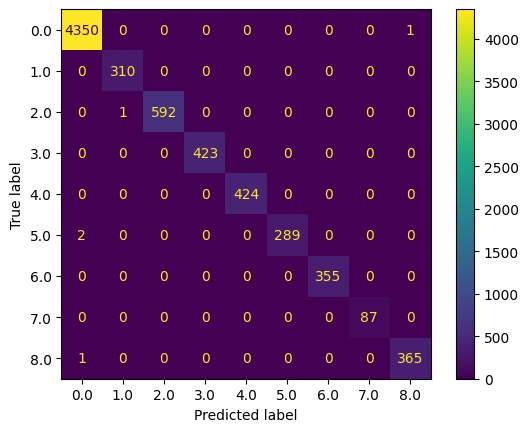

In [17]:
# get training statistics
train_acc = accuracy_score(y_train.idxmax(axis=1), y_pred_train)
train_pre = precision_score(y_train.idxmax(axis=1), y_pred_train, average='macro')
train_rec = recall_score(y_train.idxmax(axis=1), y_pred_train, average='macro')
train_f1 = f1_score(y_train.idxmax(axis=1), y_pred_train, average='macro')
print('accuracy on the train set = {:.2f}%'.format(100 * train_acc))
print('precision on the train set = {:.2f}%'.format(100 * train_pre))
print('recall on the train set = {:.2f}%'.format(100 * train_rec))
print('f1 score on the train set = {:.2f}%'.format(100 * train_f1))
print()
print(classification_report(y_train.idxmax(axis=1), y_pred_train, digits=4))
print(confusion_matrix(y_train.idxmax(axis=1), y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_train.idxmax(axis=1), y_pred_train)

accuracy on the val set = 66.62%
precision on the val set = 48.09%
recall on the val set = 42.99%
f1 score on the val set = 44.59%

              precision    recall  f1-score   support

         0.0     0.7623    0.8347    0.7968       484
         1.0     0.6216    0.6765    0.6479        34
         2.0     0.7551    0.5606    0.6435        66
         3.0     0.4091    0.3830    0.3956        47
         4.0     0.4286    0.3191    0.3659        47
         5.0     0.4667    0.2188    0.2979        32
         6.0     0.2979    0.3590    0.3256        39
         7.0     0.1538    0.2000    0.1739        10
         8.0     0.4333    0.3171    0.3662        41

    accuracy                         0.6663       800
   macro avg     0.4809    0.4299    0.4459       800
weighted avg     0.6564    0.6663    0.6562       800

[[404   3   7  15  14   5  20   6  10]
 [ 10  23   0   0   0   0   1   0   0]
 [ 19   7  37   0   1   0   0   1   1]
 [ 23   1   0  18   2   0   2   0   1]
 [ 20  

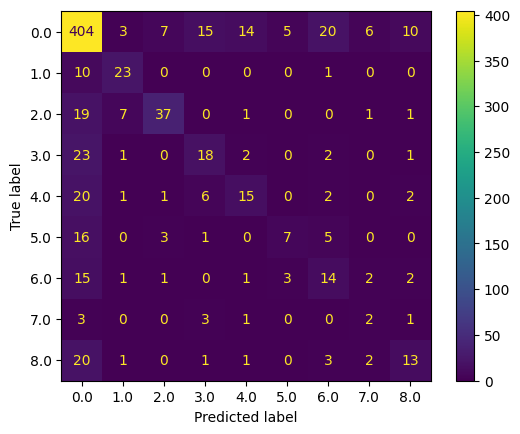

In [18]:
# get validation statistics
val_acc = accuracy_score(y_val.idxmax(axis=1), y_pred_val)
val_pre = precision_score(y_val.idxmax(axis=1), y_pred_val, average='macro')
val_rec = recall_score(y_val.idxmax(axis=1), y_pred_val, average='macro')
val_f1 = f1_score(y_val.idxmax(axis=1), y_pred_val, average='macro')
print('accuracy on the val set = {:.2f}%'.format(100 * val_acc))
print('precision on the val set = {:.2f}%'.format(100 * val_pre))
print('recall on the val set = {:.2f}%'.format(100 * val_rec))
print('f1 score on the val set = {:.2f}%'.format(100 * val_f1))
print()
print(classification_report(y_val.idxmax(axis=1), y_pred_val, digits=4))
print(confusion_matrix(y_val.idxmax(axis=1), y_pred_val))
ConfusionMatrixDisplay.from_predictions(y_val.idxmax(axis=1), y_pred_val)

PART 4: GET TESTING STATISTICS AND ANALYZE 50 RANDOM TEST SENTENCES

accuracy on the test set = 71.70%
precision on the test set = 50.76%
recall on the test set = 47.19%
f1 score on the test set = 48.49%

              precision    recall  f1-score   support

         0.0     0.8151    0.8686    0.8410      1690
         1.0     0.7704    0.7761    0.7732       134
         2.0     0.7735    0.7216    0.7467       194
         3.0     0.4500    0.4444    0.4472       162
         4.0     0.3918    0.2533    0.3077       150
         5.0     0.4658    0.3148    0.3757       108
         6.0     0.3034    0.3577    0.3284       123
         7.0     0.1538    0.1818    0.1667        22
         8.0     0.4444    0.3284    0.3777       134

    accuracy                         0.7170      2717
   macro avg     0.5076    0.4719    0.4849      2717
weighted avg     0.7041    0.7170    0.7080      2717

[[1468    9   19   48   31   21   60    6   28]
 [  17  104    6    1    0    1    2    2    1]
 [  33   13  140    1    0    4    2    0    1]
 [  60    1    

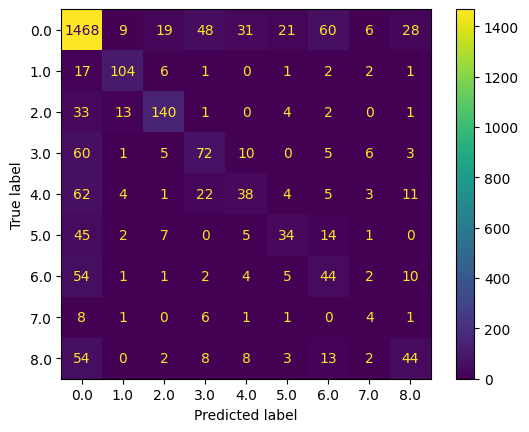

In [19]:
# get test statistics
test_acc = accuracy_score(y_test.idxmax(axis=1), y_pred_test)
test_pre = precision_score(y_test.idxmax(axis=1), y_pred_test, average='macro')
test_rec = recall_score(y_test.idxmax(axis=1), y_pred_test, average='macro')
test_f1 = f1_score(y_test.idxmax(axis=1), y_pred_test, average='macro')
print('accuracy on the test set = {:.2f}%'.format(100 * test_acc))
print('precision on the test set = {:.2f}%'.format(100 * test_pre))
print('recall on the test set = {:.2f}%'.format(100 * test_rec))
print('f1 score on the test set = {:.2f}%'.format(100 * test_f1))
print()
print(classification_report(y_test.idxmax(axis=1), y_pred_test, digits=4))
print(confusion_matrix(y_test.idxmax(axis=1), y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test.idxmax(axis=1), y_pred_test)

In [ ]:
# test the model on 50 random sentences from the test set
indices = sorted(np.random.choice(len(y_test), 50, replace=False))
label_to_relation = {
    0: 'Other', 
    1: 'Cause-Effect(e1,e2)', 
    2: 'Cause-Effect(e2,e1)',
    3: 'Component-Whole(e1,e2)', 
    4: 'Component-Whole(e2,e1)',
    5: 'Product-Producer(e1,e2)', 
    6: 'Product-Producer(e2,e1)',
    7: 'Instrument-Agency(e1,e2)', 
    8: 'Instrument-Agency(e2,e1)'
}

wrong = 0
print('sentence number\tpredicted relation\ttrue relation\tcorrect')
for i in indices:
    predicted_relation = label_to_relation[y_pred_test[i]]
    true_relation =label_to_relation[y_test.idxmax(axis=1)[i]]
    correct = 'Yes' if predicted_relation == true_relation else 'No'
    wrong += predicted_relation != true_relation
    print('{}\t{}\t{}\t{}'.format(i + 8001, predicted_relation, true_relation, correct))
print(wrong)

sentence number	predicted relation	true relation	correct
8018	Instrument-Agency(e2,e1)	Other	No
8190	Component-Whole(e2,e1)	Instrument-Agency(e2,e1)	No
8194	Component-Whole(e2,e1)	Component-Whole(e2,e1)	Yes
8327	Other	Other	Yes
8367	Other	Other	Yes
8373	Cause-Effect(e2,e1)	Cause-Effect(e2,e1)	Yes
8398	Other	Other	Yes
8476	Cause-Effect(e1,e2)	Cause-Effect(e1,e2)	Yes
8493	Cause-Effect(e2,e1)	Cause-Effect(e2,e1)	Yes
8496	Other	Other	Yes
8503	Cause-Effect(e2,e1)	Cause-Effect(e2,e1)	Yes
8562	Instrument-Agency(e2,e1)	Other	No
8591	Cause-Effect(e2,e1)	Cause-Effect(e2,e1)	Yes
8610	Other	Other	Yes
8715	Other	Other	Yes
8734	Other	Other	Yes
8793	Other	Other	Yes
8876	Other	Other	Yes
8942	Other	Other	Yes
8953	Cause-Effect(e2,e1)	Cause-Effect(e2,e1)	Yes
9034	Other	Other	Yes
9215	Other	Instrument-Agency(e2,e1)	No
9332	Other	Other	Yes
9350	Other	Other	Yes
9383	Product-Producer(e1,e2)	Other	No
9395	Other	Other	Yes
9433	Product-Producer(e2,e1)	Other	No
9487	Component-Whole(e2,e1)	Instrument-Agency(e2,e1